# Regression Analysis of Temporal Processes (Class 9) - ARIMA, Unit Roots

In [47]:
import warnings
warnings.filterwarnings("ignore")

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
from statsmodels.graphics.tsaplots import plot_acf
import pylab
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.diagnostic import acorr_ljungbox

Code from last class:

In [30]:
GSS = pd.read_csv('trends-gss.csv')
variables = ["cohort", "year", "sex", "age", "marital", "degree"]
sub = GSS[variables].copy()

In [31]:
sub['married'] = np.where(pd.isnull(sub.marital), np.nan, 
                          np.where(sub.marital==1, 1, 0))
sub['baplus'] = np.where(pd.isnull(sub.degree), np.nan, 
                         np.where(sub.degree>=3, 1, 0))

sub['marriedlt50'] = np.where(pd.isnull(sub.married) | pd.isnull(sub.age), np.nan, 
                              np.where((sub.married==1) & (sub.age<50), 1, 0))
sub['degreelt50'] = np.where(pd.isnull(sub.baplus) | pd.isnull(sub.age), np.nan,
                              np.where((sub.baplus==1) & (sub.age<50), 1, 0))

by_year = sub.groupby('year', as_index = False)[['year', 'marriedlt50', 'degreelt50']].mean()

In [4]:
sub.groupby('year', as_index = False)[['marriedlt50', 'degreelt50']].sum().head()

,year,marriedlt50,degreelt50
0,1972,712.0,123.0
1,1973,666.0,146.0
2,1974,658.0,152.0
3,1975,627.0,147.0
4,1976,599.0,152.0


In [5]:
sub.groupby('year', as_index = False).agg('count')[['year', 'marriedlt50', 'degreelt50']].head()

,year,marriedlt50,degreelt50
0,1972,1608,1586
1,1973,1500,1485
2,1974,1478,1477
3,1975,1485,1485
4,1976,1493,1487


In [32]:
add_years_df = pd.DataFrame(data = pd.Series([1979, 1981, 1992]), columns = ['year'])
by_year = pd.concat([by_year, add_years_df], sort = False, ignore_index = True)

by_year = by_year.sort_values(['year'])

#by_year['year'] = pd.to_datetime(by_year['year'], format = "%Y")
#by_year = by_year.set_index('year', drop = False)
#by_year['year'] = by_year['year'].dt.year

by_year_ts = by_year.interpolate(method = 'linear')

by_year_ts['marriedlt50_pct'] = by_year_ts['marriedlt50']*100 
by_year_ts['degreelt50_pct'] = by_year_ts['degreelt50']*100 

by_year_ts2 = by_year_ts[by_year_ts['year']<=1992].copy()
#by_year_ts2.set_index('year', drop=False, inplace=True)

## Augmented Dickey-Fuller test

<br>
The augmented Dickey-Fuller test is available in Python in the `statsmodels` module. However, we will use the functions provided in the `ARCH` package as the results offered are more comprehensive than those provided in `statsmodel`. 

In [34]:
from arch.unitroot import ADF

ADF(by_year_ts2['marriedlt50_pct'], lags = 0, trend = 'nc')

Test Statistic,-1.308
P-value,0.176
Lags,0


In [9]:
# (slide 11)
ADF(by_year_ts2['marriedlt50_pct'], lags = 4, trend = 'nc')

Test Statistic,-2.246
P-value,0.024
Lags,4


In [10]:
# (slide 12)
ADF(by_year_ts2['marriedlt50_pct'], lags = 4, trend = 'nc').regression.summary()

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     1.515
Date:                Mon, 13 Aug 2018   Prob (F-statistic):              0.263
Time:                        18:14:34   Log-Likelihood:                -30.905
No. Observations:                  16   AIC:                             71.81
Df Residuals:                      11   BIC:                             75.67
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0426      0.019     -2.246      0.046      -0.084      -0.001
x2            -0.3859      0.247     -1.564      0.146      -0.929       0.157
x3            -0.4659      0.260     -1.793      0.101      -1.038       0.106
x4            -0.2833      0.263     -1.076      0.305      -0.863       0.296
x5            -0.5177      0.253     -2.047      0.065      -1.074       0.039
==============================================================================
Omnibus:                        0.533   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.766   Jarque-Bera (JB):                0.593
Skew:                           0.205   Prob(JB):                        0.744
Kurtosis:                       2.151   Cond. No.                         25.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# (slide 15)
ADF(by_year_ts2['marriedlt50_pct'], lags = 0, trend = 'c')

Test Statistic,-1.642
P-value,0.461
Lags,0


In [12]:
# (slide 16)
ADF(by_year_ts2['marriedlt50_pct'], lags = 4, trend = 'c')

Test Statistic,-2.027
P-value,0.275
Lags,4


In [13]:
# (slide 19)
ADF(by_year_ts2['marriedlt50_pct'], lags = 0, trend = 'ct')

Test Statistic,-2.360
P-value,0.401
Lags,0


In [14]:
# (slide 20)
ADF(by_year_ts2['marriedlt50_pct'], lags = 0, trend = 'ct').regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     3.092
Date:                Mon, 13 Aug 2018   Prob (F-statistic):             0.0716
Time:                        18:14:45   Log-Likelihood:                -39.099
No. Observations:                  20   AIC:                             84.20
Df Residuals:                      17   BIC:                             87.19
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5441      0.231     -2.360      0.031      -1.031      -0.058
const         22.9549     10.235      2.243      0.039       1.360      44.549
x2            -0.2928      0.165     -1.779      0.093      -0.640       0.054
==============================================================================
Omnibus:                        0.316   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.854   Jarque-Bera (JB):                0.371
Skew:                          -0.252   Prob(JB):                        0.831
Kurtosis:                       2.562   Cond. No.                         964.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# (slide 21)
ADF(by_year_ts2['marriedlt50_pct'], lags = 4, trend = 'ct')

Test Statistic,-0.359
P-value,0.988
Lags,4


## Phillips-Perron test
(slide 23)

In [16]:
from arch.unitroot import PhillipsPerron

PhillipsPerron(by_year_ts2['marriedlt50_pct'], lags = 2)

Test Statistic,-1.597
P-value,0.485
Lags,2


## What do we do if we have unit roots?

In [35]:
# (slide 27)
by_yearFD = pd.DataFrame()

# grab the variables from by_year_ts2 that we want to take the first differences of
by_yearFD = by_year_ts2[['marriedlt50_pct', 'degreelt50_pct']]
by_yearFD = by_yearFD.diff()

by_yearFD['year'] = by_year_ts2['year']

The `ADF` function doesn't accept nan values, so we have to drop them in the data frame. As such, the results might be a bit different compared to the results from R.

In [36]:
by_yearFD2 = by_yearFD.dropna()

In [37]:
# (slide 27)

ADF(by_yearFD2['marriedlt50_pct'], lags = 0, trend = 'ct')

Test Statistic,-5.202
P-value,0.000
Lags,0


In [20]:
# (slide 28)

ADF(by_yearFD2['degreelt50_pct'], lags = 0, trend = 'ct')

Test Statistic,-5.127
P-value,0.000
Lags,0


### The difference model
(slide 29)

In [21]:
lm_Dmarried = smf.ols('marriedlt50_pct ~ degreelt50_pct + year', data = by_yearFD).fit()
lm_Dmarried.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        marriedlt50_pct   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     6.102
Date:                Mon, 13 Aug 2018   Prob (F-statistic):             0.0101
Time:                        18:14:57   Log-Likelihood:                -36.791
No. Observations:                  20   AIC:                             79.58
Df Residuals:                      17   BIC:                             82.57
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -113.7794    126.990     -0.896      0.383    -381.705     154.146
degreelt50_pct     1.3279      0.393      3.380      0.004       0.499       2.157
year               0.0569      0.064      0.888      0.387      -0.078       0.192
==============================================================================
Omnibus:                        0.554   Durbin-Watson:                   2.536
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.605
Skew:                           0.324   Prob(JB):                        0.739
Kurtosis:                       2.446   Cond. No.                     6.82e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Autocorrelations of the differences
(slide 30)

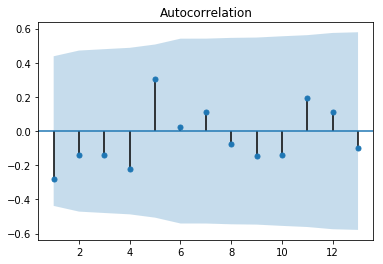

In [258]:
e3 = lm_Dmarried.resid
plot_acf(e3, lags = 13, zero = False);

Text(0,0.5,'e3')

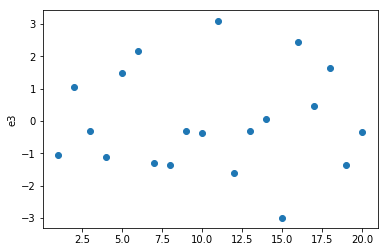

In [259]:
pylab.scatter(e3.index, e3)
pylab.ylabel('e3')

In [260]:
# (slide 32)

durbin_watson(e3)

2.5363286307482955

In [261]:
# Breusch-Godfrey test

lmtest, pval, fval, f_pval = acorr_breusch_godfrey(lm_Dmarried, nlags = 1)
print('LM test =', lmtest)
print('p-value =', pval)

LM test = 1.7487111184182447
p-value = 0.18603884480084537


In [22]:
# slide 33
lmtest, pval, fval, f_pval = acorr_breusch_godfrey(lm_Dmarried, nlags = 4)
print('LM test =', lmtest)
print('p-value =', pval)

LM test = 9.113700283000764
p-value = 0.05831950289393525


## ARIMA models

ARIMA models are difficult to estimate. Therefore, it's common for different software to produce slightly different results as they use different methods of estimation, and different optimization algorithms.

In [49]:
# slide 38
from statsmodels.tsa.arima_model import ARIMA

arima_married100 = ARIMA(by_year_ts2['marriedlt50_pct'], order = (1, 0, 0), exog = by_year_ts2[['degreelt50_pct', 'year']]).fit()
arima_married100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        marriedlt50_pct   No. Observations:                   21
Model:                     ARMA(1, 0)   Log Likelihood                 -35.579
Method:                       css-mle   S.D. of innovations              1.312
Date:                Mon, 13 Aug 2018   AIC                             81.159
Time:                        18:46:44   BIC                             86.381
Sample:                             0   HQIC                            82.292
                                                                              
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2222.4478    255.775      8.689      0.000    1721.137    2723.758
degreelt50_pct            1.5126      0.316      4.790      0.000       0.894       2.132
year                     -1.1114      0.131     -8.512      0.000      -1.367      -0.856
ar.L1.marriedlt50_pct     0.3779      0.220      1.720      0.104      -0.053       0.808
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.6464           +0.0000j            2.6464            0.0000
-----------------------------------------------------------------------------
"""

<br>
Plotting residuals:

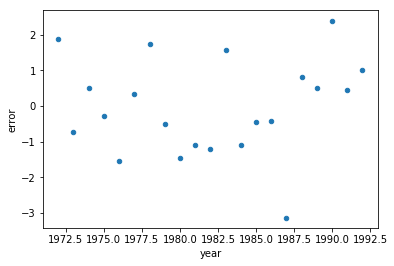

In [265]:
# Get residuals, set to dataframe, and rename error column
arima_married100_err = arima_married100.resid.to_frame().reset_index().rename(columns={0: 'error'})

arima_married100_err['year'] = by_year_ts2['year']

arima_married100_err.plot.scatter(x='year', y='error')

<br>
Plotting ACF of residuals

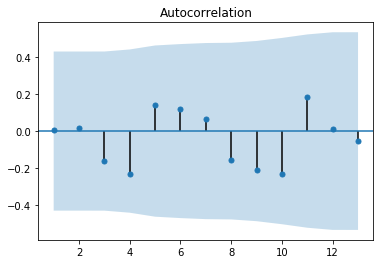

In [266]:
plot_acf(arima_married100.resid, lags = 13, zero = False);

# see https://github.com/statsmodels/statsmodels/issues/4870, maybe use SARIMAX instead

In [50]:
# slide 40

arima_married010 = ARIMA(by_year_ts2['marriedlt50_pct'], order = (0, 1, 0), exog = by_year_ts2[['degreelt50_pct', 'year']]).\
                    fit(trend='nc')

In [51]:
arima_married010.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.marriedlt50_pct   No. Observations:                   20
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -41.663
Method:                           css   S.D. of innovations              1.943
Date:                Mon, 13 Aug 2018   AIC                             89.326
Time:                        18:46:49   BIC                             92.313
Sample:                             1   HQIC                            89.909
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
degreelt50_pct     0.2348      0.223      1.055      0.305      -0.201       0.671
year              -0.0017      0.001     -1.232      0.234      -0.004       0.001
==================================================================================
"""

In [52]:
arima_married520 = ARIMA(by_year_ts2['marriedlt50_pct'], order = (5, 2, 0), exog = by_year_ts2['degreelt50_pct']).\
                    fit(start_params=[1, .05, .05, .1, .1, .1], trend = 'nc')

In [452]:
arima_married520.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D2.marriedlt50_pct   No. Observations:                   19
Model:                 ARIMA(5, 2, 0)   Log Likelihood                 -39.067
Method:                       css-mle   S.D. of innovations              1.753
Date:                Sat, 11 Aug 2018   AIC                             92.134
Time:                        20:06:50   BIC                             98.746
Sample:                    01-01-1974   HQIC                            93.253
                         - 01-01-1992                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
degreelt50_pct               0.0052      0.007      0.701      0.496      -0.009       0.020
ar.L1.D2.marriedlt50_pct    -1.0515      0.221     -4.755      0.000      -1.485      -0.618
ar.L2.D2.marriedlt50_pct    -1.0532      0.252     -4.180      0.001      -1.547      -0.559
ar.L3.D2.marriedlt50_pct    -0.8719      0.289     -3.014      0.010      -1.439      -0.305
ar.L4.D2.marriedlt50_pct    -0.8489      0.243     -3.492      0.004      -1.325      -0.372
ar.L5.D2.marriedlt50_pct    -0.3298      0.223     -1.482      0.162      -0.766       0.106
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4118           -1.0337j            1.1127           -0.1897
AR.2            0.4118           +1.0337j            1.1127            0.1897
AR.3           -0.7823           -0.8509j            1.1558           -0.3683
AR.4           -0.7823           +0.8509j            1.1558            0.3683
AR.5           -1.8331           -0.0000j            1.8331           -0.5000
-----------------------------------------------------------------------------
"""

In [382]:
# Create a new dataframe containing the necessary columns we will graph
year = pd.Series(by_year_ts2['year'], name='year')

marriedlt50pct = pd.Series(by_year_ts2['marriedlt50_pct'], name='marriedlt50_pct')
D1_marriedlt50_pct = pd.Series(by_year_ts2['marriedlt50_pct'].diff(), name='D1_marriedlt50_pct')
D2_marriedlt50_pct = pd.Series(D1_marriedlt50_pct.diff(), name='D2_marriedlt50_pct')

degreelt50_pct = pd.Series(by_year_ts2['degreelt50_pct'], name='degreelt50_pct')
D1_degreelt50_pct = pd.Series(by_year_ts2['degreelt50_pct'].diff(), name='D1_degreelt50_pct')
D2_degreelt50_pct = pd.Series(D1_degreelt50_pct.diff(), name='D2_degreelt50_pct')

Diff_dat = pd.concat([year, marriedlt50pct, D1_marriedlt50_pct, D2_marriedlt50_pct,
                      degreelt50_pct, D1_degreelt50_pct, D2_degreelt50_pct], axis=1)

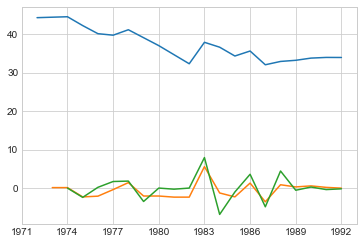

In [383]:
# slide 43
plt.style.use('seaborn-whitegrid')

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(Diff_dat['year'], Diff_dat['marriedlt50_pct'])
plt.plot(Diff_dat['year'], Diff_dat['D1_marriedlt50_pct'])
plt.plot(Diff_dat['year'], Diff_dat['D2_marriedlt50_pct'])

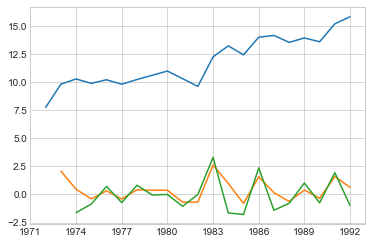

In [314]:
# slide 44
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(Diff_dat['year'], Diff_dat['degreelt50_pct'])
plt.plot(Diff_dat['year'], Diff_dat['D1_degreelt50_pct'])
plt.plot(Diff_dat['year'], Diff_dat['D2_degreelt50_pct'])

<br>
Box-pierce test on `arima_married520`:

In [384]:
arima_married520_resid = arima_married520.resid

acorr_ljungbox(arima_married520_resid, boxpierce=True)[3]

array([0.64894117, 0.67619561, 0.83165904, 0.79482279, 0.87511556,
       0.92872286, 0.94273362])

<br>
Try ARIMA(5, 1, 0):

In [399]:
Diff_dat1 = Diff_dat[['D1_marriedlt50_pct', 'D1_degreelt50_pct']].copy()

Diff_dat1.dropna(inplace=True)

In [459]:
# slide 47

arima_married510 = ARIMA(by_year_ts2['marriedlt50_pct'], order = (5, 1, 0), exog = by_year_ts2['degreelt50_pct']).\
                        fit(trend='nc', start_params=[1, .1, .1, .1, .1, .1]) 


/Users/melindasong/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/Users/melindasong/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


In [460]:
arima_married510.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.marriedlt50_pct   No. Observations:                   20
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -39.359
Method:                       css-mle   S.D. of innovations              1.693
Date:                Sat, 11 Aug 2018   AIC                             92.719
Time:                        20:22:46   BIC                             99.689
Sample:                    01-01-1973   HQIC                            94.079
                         - 01-01-1992                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
degreelt50_pct             -0.0402      0.020     -2.058      0.059      -0.078      -0.002
ar.L1.D.marriedlt50_pct    -0.1829      0.232     -0.789      0.443      -0.637       0.271
ar.L2.D.marriedlt50_pct    -0.3105      0.213     -1.459      0.167      -0.728       0.107
ar.L3.D.marriedlt50_pct    -0.0930      0.237     -0.393      0.700      -0.557       0.371
ar.L4.D.marriedlt50_pct    -0.3232      0.221     -1.466      0.165      -0.755       0.109
ar.L5.D.marriedlt50_pct     0.1803      0.236      0.763      0.458      -0.283       0.643
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8627           -0.8103j            1.1835           -0.3800
AR.2           -0.8627           +0.8103j            1.1835            0.3800
AR.3            0.5147           -1.1517j            1.2615           -0.1831
AR.4            0.5147           +1.1517j            1.2615            0.1831
AR.5            2.4886           -0.0000j            2.4886           -0.0000
-----------------------------------------------------------------------------
"""

In [433]:
arima_married510_resid = arima_married510.resid

acorr_ljungbox(arima_married510_resid, boxpierce=True)[3]

array([0.87542941, 0.98542696, 0.98559079, 0.98823956, 0.96837906,
       0.98418066, 0.99421307, 0.98935714])

The `auto_arima` function from the `pyramid` package can be used to automatically select the optimum parameters for the ARIMA model by computing the comparing AIC values. 